e:\3395-competition2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


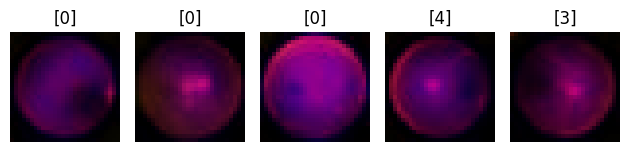

[486 128 206 194  66]


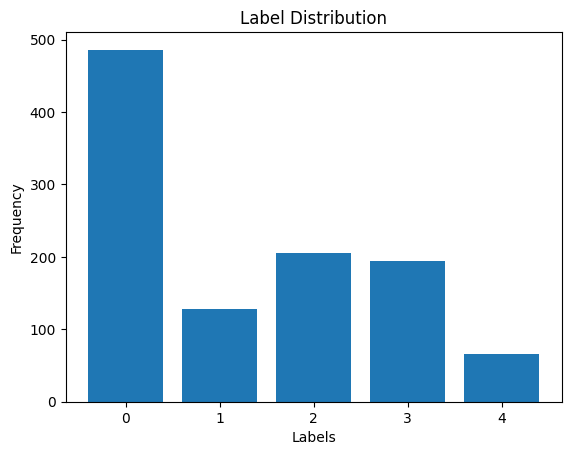

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import csv
import optuna
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Load the data
with open('data/train_data.pkl', 'rb') as f:
    data = pickle.load(f)

images = data['images']
labels = data['labels']

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])   
    plt.title(f"{labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

unique_labels = np.unique(labels, return_counts=True)
print(unique_labels[1])
plt.bar(unique_labels[0], unique_labels[1])
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.show()



In [2]:
class SoftmaxRegression:
    def __init__(self, lr=0.01, num_epochs=50, batch_size=64, reg=0.0001):
        self.lr = lr
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.reg = reg
        self.W = None
        self.b = None

    def softmax(self, z):
        z -= np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def one_hot(self, y, K):
        oh = np.zeros((len(y), K))
        oh[np.arange(len(y)), y] = 1
        return oh

    def fit(self, X, y):
        _, d = X.shape
        K = np.max(y) + 1

        if self.W is None:
            self.W = np.zeros((d, K))
            self.b = np.zeros(K)

        # Build a dictionary of indices per class
        class_indices = {cls: np.where(y == cls)[0] for cls in np.unique(y)}
        max_count = max(len(idx) for idx in class_indices.values())

        # Oversample to balance classes
        balanced_indices = []
        for _, idxs in class_indices.items():
            repeat_times = max_count // len(idxs)
            remainder = max_count % len(idxs)
            oversampled = np.tile(idxs, repeat_times)
            oversampled = np.concatenate([oversampled, np.random.choice(idxs, remainder, replace=False)])
            balanced_indices.extend(oversampled)
        balanced_indices = np.array(balanced_indices)

        for epoch in range(self.num_epochs):
            np.random.shuffle(balanced_indices)

            for start in range(0, len(balanced_indices), self.batch_size):
                end = start + self.batch_size
                batch_idx = balanced_indices[start:end]

                X_batch = X[batch_idx]
                y_batch = y[batch_idx]
                Y_onehot = self.one_hot(y_batch, K)

                # Forward pass
                logits = X_batch @ self.W + self.b
                probs = self.softmax(logits)

                # Gradients
                m = len(X_batch)
                grad_W = (1/m) * X_batch.T @ (probs - Y_onehot) + self.reg * self.W
                grad_b = (1/m) * np.sum(probs - Y_onehot, axis=0)

                # Update
                self.W -= self.lr * grad_W
                self.b -= self.lr * grad_b

            # Compute full epoch loss on balanced data
            logits_full = X[balanced_indices] @ self.W + self.b
            probs_full = self.softmax(logits_full)
            Y_onehot_full = self.one_hot(y[balanced_indices], K)
            ce_loss = -np.mean(np.sum(Y_onehot_full * np.log(probs_full + 1e-8), axis=1))
            reg_loss = 0.5 * self.reg * np.sum(self.W**2)
            total_loss = ce_loss + reg_loss

            print(f"Epoch {epoch+1}/{self.num_epochs} - Loss: {total_loss:.4f}")    

    def predict(self, X):
        logits = X @ self.W + self.b
        return np.argmax(logits, axis=1)

    def accuracy(self, X, y):
        return np.mean(self.predict(X) == y)


Epoch 1/200 - Loss: 8.0486
Epoch 2/200 - Loss: 8.2965
Epoch 3/200 - Loss: 8.0595
Epoch 4/200 - Loss: 8.0691
Epoch 5/200 - Loss: 8.0815
Epoch 6/200 - Loss: 8.0966
Epoch 7/200 - Loss: 8.1145
Epoch 8/200 - Loss: 8.1352
Epoch 9/200 - Loss: 8.1586
Epoch 10/200 - Loss: 8.1848
Epoch 11/200 - Loss: 8.2137
Epoch 12/200 - Loss: 8.2454
Epoch 13/200 - Loss: 8.2800
Epoch 14/200 - Loss: 8.3171
Epoch 15/200 - Loss: 8.3570
Epoch 16/200 - Loss: 8.3997
Epoch 17/200 - Loss: 8.4452
Epoch 18/200 - Loss: 8.4933
Epoch 19/200 - Loss: 8.8202
Epoch 20/200 - Loss: 8.5977
Epoch 21/200 - Loss: 8.9325
Epoch 22/200 - Loss: 8.7127
Epoch 23/200 - Loss: 8.7746
Epoch 24/200 - Loss: 8.8395
Epoch 25/200 - Loss: 9.2390
Epoch 26/200 - Loss: 8.9768
Epoch 27/200 - Loss: 9.0496
Epoch 28/200 - Loss: 9.4712
Epoch 29/200 - Loss: 9.2032
Epoch 30/200 - Loss: 9.5360
Epoch 31/200 - Loss: 9.3677
Epoch 32/200 - Loss: 9.4542
Epoch 33/200 - Loss: 9.5437
Epoch 34/200 - Loss: 9.6357
Epoch 35/200 - Loss: 9.7306
Epoch 36/200 - Loss: 9.8285
E

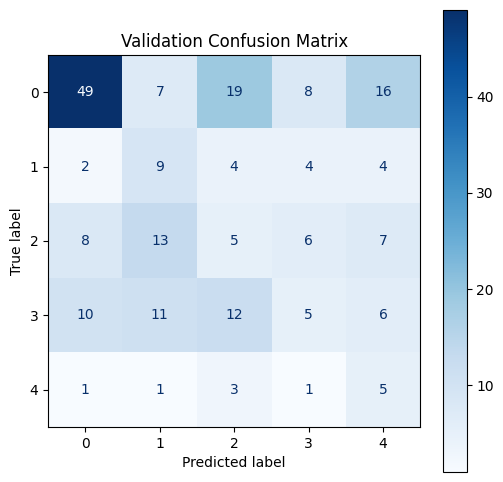

In [3]:
np.random.seed(0)

X = images.reshape(len(images), -1) / 255.0
Y = labels.astype(int)

idx = np.random.permutation(len(X))
split = int(0.8 * len(X))

X_train, X_val = X[idx[:split]], X[idx[split:]]
Y_train, Y_val = Y[idx[:split]], Y[idx[split:]]

# def objective(trial):
#     # Suggest hyperparameters
#     lr = trial.suggest_float('lr', 1e-4, 1e-1)
#     num_epochs = trial.suggest_int('num_epochs', 50, 500)
#     batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
#     reg = trial.suggest_float('reg', 1e-5, 1e-1)

#     # Initialize model
#     model = SoftmaxRegression(lr=lr, num_epochs=num_epochs, batch_size=batch_size, reg=reg)
#     model.fit(X_train, Y_train)

#     # Evaluate on validation set
#     val_acc = model.accuracy(X_val, Y_val)

#     # We want to maximize accuracy
#     return 1.0 - val_acc  # Optuna minimizes, so 1 - accuracy

# # Create study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=30)  # Run 30 trials

model = SoftmaxRegression(lr=0.01, num_epochs=200, batch_size=64)
model.fit(X_train, Y_train)

print("Validation accuracy:", model.accuracy(X_val, Y_val))
print("Training accuracy:", model.accuracy(X_train, Y_train))
# print("Best hyperparameters:", study.best_params)
# print("Best validation accuracy:", 1 - study.best_value)

# After training
Y_val_pred = model.predict(X_val)

# Compute confusion matrix
cm = confusion_matrix(Y_val, Y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(Y_val))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
plt.title("Validation Confusion Matrix")
plt.show()


In [4]:
with open("data/test_data.pkl", "rb") as f:
    test_data = pickle.load(f)

X_test = test_data["images"]

X_test = X_test.reshape(len(X_test), -1).astype(np.float32) / 255.0
y_pred = model.predict(X_test)

with open("submission.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "Label"])
    for i, label in enumerate(y_pred, start=1):
        writer.writerow([i, label])